In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [11]:
csv_files = ['all1.2.csv','all09.2.csv','all08.2.csv','all07.2.csv','all06.2.csv','all05.2.csv'] # Passen Sie diese Liste an!
#csv_files = ['all1.2.csv']

all_dataframes = []

In [12]:
for file in csv_files:
    try:
        # Laden jeder CSV-Datei
        df_temp = pd.read_csv(file)
        all_dataframes.append(df_temp)
    except FileNotFoundError:
        print(f"\nACHTUNG: Die Datei '{file}' wurde nicht gefunden und wird übersprungen.")
        print("Bitte stellen Sie sicher, dass sie sich im selben Ordner wie das Skript befindet.")

# Überprüfen, ob mindestens eine Datei geladen wurde
if not all_dataframes:
    print("\nFEHLER: Keine Daten zum Analysieren vorhanden. Das Skript wird beendet.")
    exit()

# Alle geladenen Daten zu einem einzigen DataFrame zusammenfügen
df = pd.concat(all_dataframes, ignore_index=True)

In [13]:
df = df[~df['strategy'].isin(['Split', 'Combined_Split'])]


In [17]:
csv_files_split = ['1.08.csv','09.08.csv','08.09.csv','07.10.csv','06.10.csv','05.10.csv']

split_dataframes = []

In [18]:
for file in csv_files_split:
    try:
        # Laden jeder CSV-Datei
        df_temp = pd.read_csv(file)
        split_dataframes.append(df_temp)
    except FileNotFoundError:
        print(f"\nACHTUNG: Die Datei '{file}' wurde nicht gefunden und wird übersprungen.")
        print("Bitte stellen Sie sicher, dass sie sich im selben Ordner wie das Skript befindet.")

# Überprüfen, ob mindestens eine Datei geladen wurde
if not split_dataframes:
    print("\nFEHLER: Keine Daten zum Analysieren vorhanden. Das Skript wird beendet.")
    exit()

# Alle geladenen Daten zu einem einzigen DataFrame zusammenfügen
dfsplit = pd.concat(split_dataframes, ignore_index=True)
df_combined = pd.concat([dfsplit, df], ignore_index=True)


In [19]:
# Filtern nach den relevanten Strategien
strategies_to_analyze = ['Standard', 'Split','Repositioning','Combined_Split']

#strategies = ["Standard","Split"]
strategies = ["Standard","Split",'Repositioning','Combined_Split']
#scale = [1.0,0.8,0.6]
scale = [1.0,0.9,0.8,0.7,0.6,0.5]

df = df_combined[df_combined["strategy"].isin(strategies)& df_combined['scale'].isin(scale)]

df_filtered = df
# Berechnung der Metriken
df_filtered['on_time_rate'] = (df_filtered['on_time_deliveries'] / df_filtered['total_delivered']) * 100
df_filtered['stacking_percentage'] = (df_filtered['stacked_assignments'] / df_filtered['total_delivered']) * 100

# Gruppieren, um die Durchschnittswerte zu ermitteln
df_summary = df_filtered.groupby(['scale', 'strategy']).agg(
    on_time_rate=('on_time_rate', 'mean'),
    stacking_percentage=('stacking_percentage', 'mean')
).reset_index()

# Sortieren der Daten für eine logische Reihenfolge in den Grafiken
df_summary = df_summary.sort_values('scale', ascending=False)

# Erstellen der textbasierten Spalte für die Achsenbeschriftung
df_summary['scale_str'] = (df_summary['scale'] * 100).astype(int).astype(str) + '%'

In [20]:
df_filtered.to_csv("all.csv")

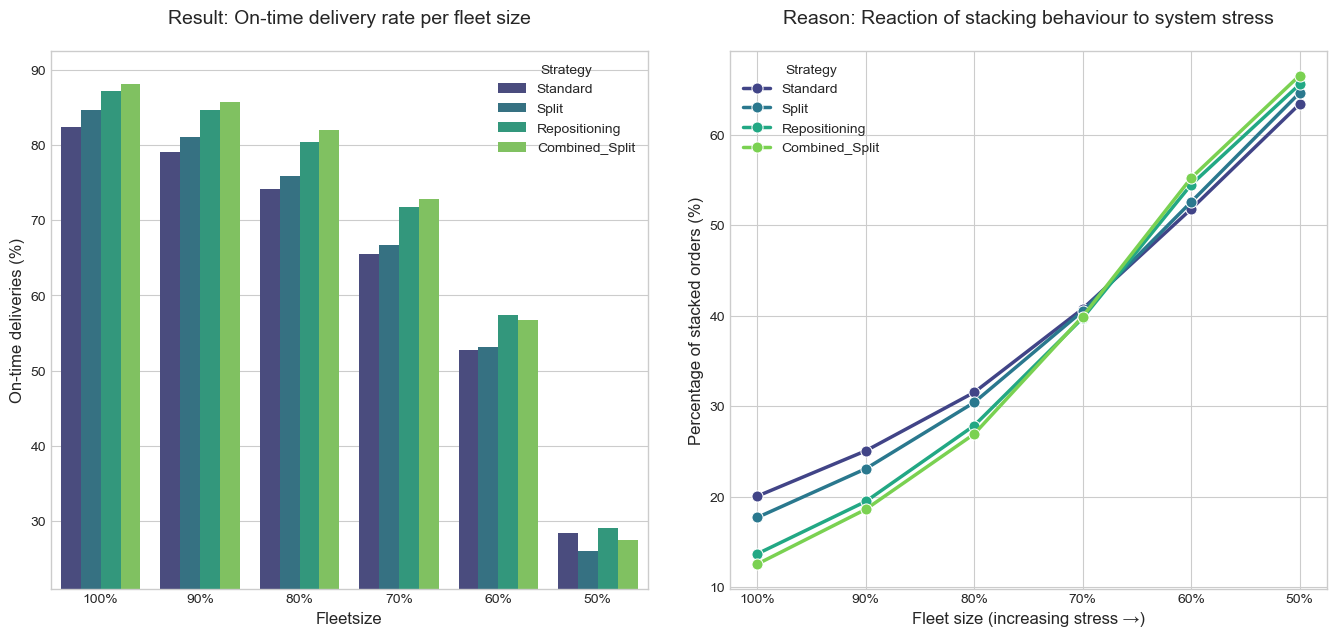

In [24]:
# --- Schritt 3: Visualisierung ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7)) # Etwas breiter für mehr Daten

# Grafik 1: Pünktlichkeit
sns.barplot(data=df_summary, x='scale_str', y='on_time_rate', hue='strategy', ax=ax1, palette='viridis')
ax1.set_title('Result: On-time delivery rate per fleet size', fontsize=14, pad=20)
ax1.set_ylabel('On-time deliveries (%)', fontsize=12)
ax1.set_xlabel('Fleetsize', fontsize=12)
if not df_summary['on_time_rate'].empty:
    ax1.set_ylim(bottom=df_summary['on_time_rate'].min() - 5)
ax1.legend(title='Strategy')

# Grafik 2: Stacking-Verhalten
sns.lineplot(data=df_summary, x='scale_str', y='stacking_percentage', hue='strategy',
             marker='o', markersize=8, linewidth=2.5, ax=ax2,
             sort=False, palette='viridis')

ax2.set_title('Reason: Reaction of stacking behaviour to system stress', fontsize=14, pad=20)
ax2.set_ylabel('Percentage of stacked orders (%)', fontsize=12)
ax2.set_xlabel('Fleet size (increasing stress →)', fontsize=12)
ax2.legend(title='Strategy')

plot_dir = "graphics"
os.makedirs(plot_dir, exist_ok=True)

plt.tight_layout(pad=3.0)
result_plot_filename = os.path.join(plot_dir, f"result_with_stacking.svg")
plt.savefig(result_plot_filename, format='svg', bbox_inches='tight')
plt.show()

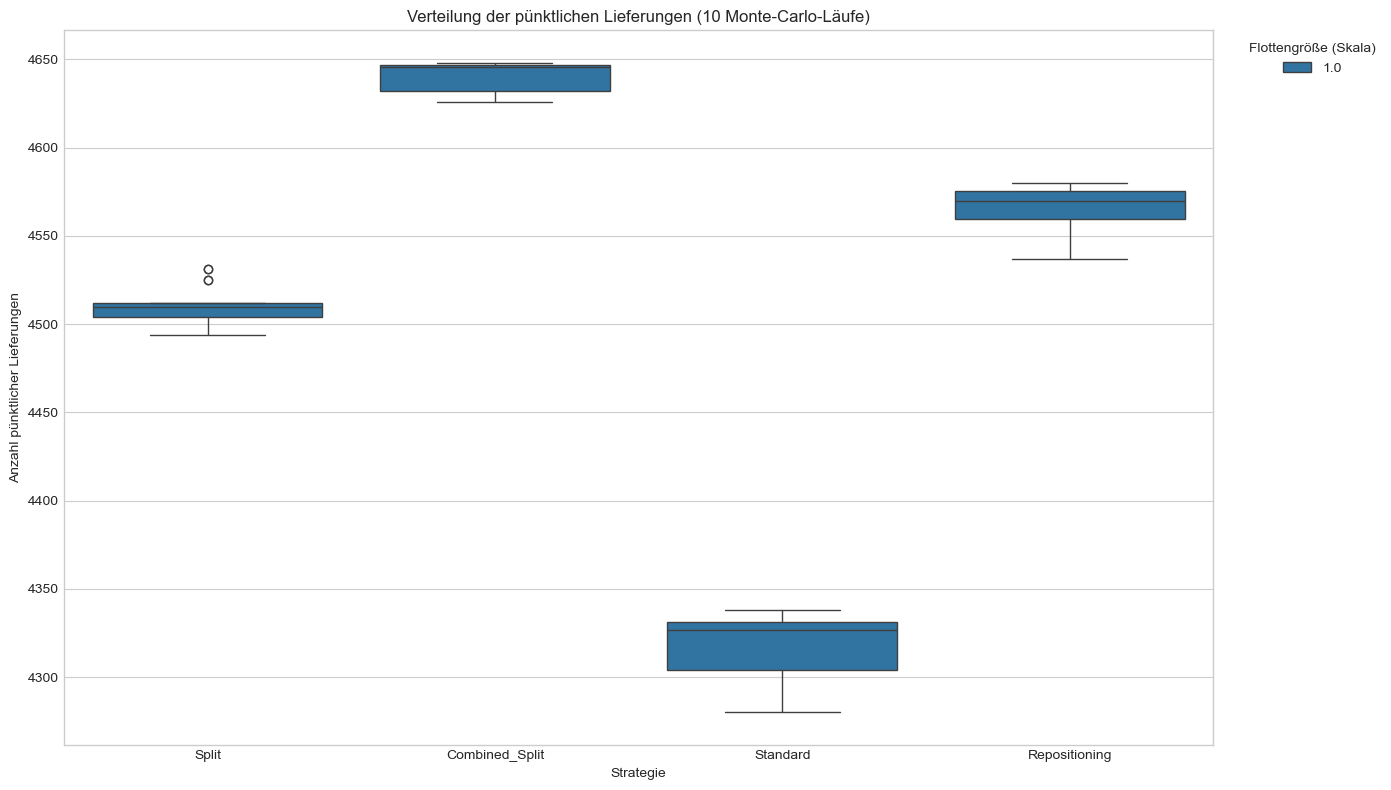

In [57]:
num_monte_carlo_runs = 10
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='strategy', y='on_time_deliveries', hue='scale')
plt.title(f'Verteilung der pünktlichen Lieferungen ({num_monte_carlo_runs} Monte-Carlo-Läufe)')
plt.xlabel('Strategie')
plt.ylabel('Anzahl pünktlicher Lieferungen')
plt.legend(title='Flottengröße (Skala)', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()